In [116]:
%run set_up.py 
%run filter_records_by_location.ipynb

import pyrosm
import geopandas as gpd
import shapely
import os

test_pts_path = os.path.join(datdir, 'test_gages', 'test_gages.shp')
osm_dir = os.path.join(datdir, 'osm')

In [132]:
test_gadm_lev1 = get_gadm_lev1_dict(
    in_gadm_path=gadm_path,
    in_vector=test_pts_path,
    hull=True,
    sjoin_predicate='intersects'
)
admin_to_get = [x.lower() for x in test_gadm_lev1.NAME_1.unique()]
print(admin_to_get)

['arkansas', 'illinois', 'indiana', 'iowa', 'kentucky', 'minnesota', 'missouri', 'tennessee', 'wisconsin']


In [52]:
"""
Downloads and processes OSM waterway data using pyrosm, filters for rivers and streams,
and optionally subsets it with a polygon GeoDataFrame.

Args:
    bbox (tuple, list, shapely.geometry.Polygon, or shapely.geometry.MultiPolygon):
        Bounding box (north, south, east, west) or a Shapely Polygon.
    polygon_file (str, optional): Path to a polygon file for subsetting. Defaults to None.
    polygon_layer (str, optional): Layer name if polygon_file is a GeoPackage. Defaults to None.

Returns:
    geopandas.GeoDataFrame:  Filtered (and optionally subsetted) GeoDataFrame, or None if an error occurs.

Raises:
    TypeError: If bbox is not a tuple, list, Polygon, or MultiPolygon.
    ValueError: If bbox coordinates are invalid.
    Exception:  For other errors during data retrieval or processing
"""

'\nDownloads and processes OSM waterway data using pyrosm, filters for rivers and streams,\nand optionally subsets it with a polygon GeoDataFrame.\n\nArgs:\n    bbox (tuple, list, shapely.geometry.Polygon, or shapely.geometry.MultiPolygon):\n        Bounding box (north, south, east, west) or a Shapely Polygon.\n    polygon_file (str, optional): Path to a polygon file for subsetting. Defaults to None.\n    polygon_layer (str, optional): Layer name if polygon_file is a GeoPackage. Defaults to None.\n\nReturns:\n    geopandas.GeoDataFrame:  Filtered (and optionally subsetted) GeoDataFrame, or None if an error occurs.\n\nRaises:\n    TypeError: If bbox is not a tuple, list, Polygon, or MultiPolygon.\n    ValueError: If bbox coordinates are invalid.\n    Exception:  For other errors during data retrieval or processing\n'

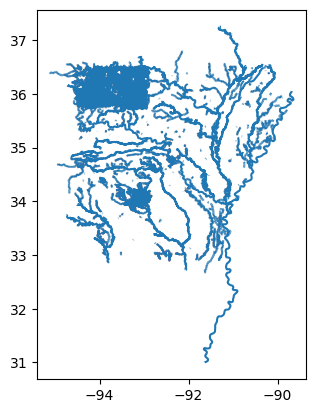

In [142]:
def get_osm_waterways_pyrosm(in_country=None, in_bbox=None, out_dir=None): #, polygon_file=None, polygon_layer=None
    # Create output directory if it doesn't exist
    if not os.path.exists(out_dir):
        print(f'Creating {out_dir}')
        os.makedirs(out_dir)
        
    #Bounding Box Handling -----------------------------------------------------
    if in_bbox:
        if isinstance(bbox, (tuple, list)): #minx, miny, maxx, maxy
            if len(bbox) != 4:
                raise ValueError("Bounding box must have 4 coordinates (north, south, east, west)")
            west, south, east, north = bbox
            bbox_polygon = shapely.box(xmin=west, ymin=south, 
                                                xmax=east, ymax=north)  # Use shapely.geometry.box
        elif isinstance(bbox, (shapely.geometry.Polygon, shapely.geometry.MultiPolygon)):
            bbox_polygon = bbox
            west, south, east, north = bbox_polygon.bounds
        else:
            raise TypeError("bbox must be a tuple, list, Polygon, or MultiPolygon")
   
    # --- Download PBF (if it doesn't exist) ---
    # Use get_data to automatically download a suitable PBF file
    fp = pyrosm.get_data(in_country, directory=out_dir)  # Downloads to current directory

    if not os.path.exists(fp):
        print(f"Could not download PBF file for the given bounding box.")
        return None
        
    # --- Initialize OSM Object ---
    osm = OSM(fp)

    # Initialize with bounding box
    # osm = OSM(fp, bounding_box=bbox_geom)
    # Bounding box is now stored as an attribute 
    #osm.bounding_box

    # # --- Get Waterways (Filtered During Read) ---
    # # This is the key performance advantage of pyrosm: filtering *during* the read.
    # waterways = osm.get_waterway(custom_filter={"waterway": }
    sel_waterway_types = ["river", "stream", "wadi", "waterway"]
    waterways = osm.get_data_by_custom_criteria(
        custom_filter={'waterway': sel_waterway_types},
        filter_type="keep",
        keep_nodes=False, 
        keep_ways=True, 
        keep_relations=True)
    waterways.plot()


    # if waterways is None or waterways.empty:
    #     print("No rivers or streams found within the bounding box.")
    #     return None
    
    # print(f"Read {len(waterways)} rivers and streams using pyrosm.  Inspecting...")
    # print(waterways.info())


#test_bbox = gpd.read_file(test_pts_path).total_bounds.tolist() #minx, miny, maxx, maxy

get_osm_waterways_pyrosm(
    in_country=admin_to_get[0], 
    in_bbox=None, 
    out_dir=osm_dir)

In [92]:
suggest = Suggest()
chicago = shapely.geometry.box(-87.629, 41.878, -87.614, 41.902)
abuja = shapely.geometry.box(7.5, 9.5, 7.6, 9.6)

print(suggest.continents(chicago))
print(suggest.cities(chicago))

[]
[]


In [ ]:

        # --- Subsetting (Optional) ---
        if polygon_file:
            try:
                if polygon_layer:
                    polygon_gdf = gpd.read_file(polygon_file, layer=polygon_layer)
                else:
                    polygon_gdf = gpd.read_file(polygon_file)

                # Ensure same CRS (reproject if needed)
                if waterways.crs != polygon_gdf.crs:
                    print(f"Reprojecting polygons to {waterways.crs}")
                    polygon_gdf = polygon_gdf.to_crs(waterways.crs)

                waterways_subset = waterways.clip(polygon_gdf)

                if waterways_subset.empty:
                    print("No rivers/streams within polygons after subsetting.")
                    return None
                else:
                    print(f"Subsetted to {len(waterways_subset)} rivers/streams.")
                    return waterways_subset

            except Exception as e:
                print(f"Error reading or processing polygon file: {e}")
                return None

        else: # Return without subsetting.
            return waterways


    except Exception as e:
        print(f"An error occurred: {e}")
        return None
    finally:
        # Clean up the downloaded PBF file (optional, but good practice)
        if 'fp' in locals() and os.path.exists(fp):  # Check if fp was defined
            os.remove(fp)

In [ ]:
# --- Example Usage ---

# 1. Download using a bounding box (tuple):
bbox = (34.3, 33.5, -117.5, -118.6)  # (north, south, east, west)
rivers_bbox_pyrosm = process_osm_waterways_pyrosm(bbox)
if rivers_bbox_pyrosm is not None:
    print("\nRivers and streams within bounding box (pyrosm, first 5 rows):")
    print(rivers_bbox_pyrosm.head())


# --- Create a dummy GeoPackage (for demonstration) ---
data = {'id': [1, 2],
        'geometry': [Polygon([(-118.2, 33.7), (-118.1, 33.7), (-118.1, 33.8), (-118.2, 33.8)]),
                     Polygon([(-117.8, 33.9), (-117.7, 33.9), (-117.7, 34.0), (-117.8, 34.0)])]}
dummy_gdf = gpd.GeoDataFrame(data, crs="EPSG:4326")
dummy_gdf.to_file("dummy_polygons3.gpkg", layer='basins', driver="GPKG")

# 2. Download with bbox AND subset with polygons:
bbox = (34.3, 33.5, -117.5, -118.6)
rivers_subset_pyrosm = process_osm_waterways_pyrosm(bbox, polygon_file="dummy_polygons3.gpkg", polygon_layer="basins")

if rivers_subset_pyrosm is not None:
    print("\nRivers and streams (pyrosm, subsetted, first 5 rows):")
    print(rivers_subset_pyrosm.head())

os.remove("dummy_polygons3.gpkg") #Cleanup

In [8]:
#See https://buntinglabs.com/blog/download-openstreetmap-osm-data-into-geopandas
import geopandas as gpd
import urllib.request
import matplotlib.pyplot as plt

bbox = '-118.526344,33.969559,-118.375969,34.072284'
tags = 'highway=primary'
# Get a key here: https://buntinglabs.com/account/register
api_key = 'YOUR_API_KEY_HERE'

url = f"https://osm.buntinglabs.com/v1/osm/extract?bbox={bbox}&tags={tags}&api_key={api_key}"

with urllib.request.urlopen(url) as response:
    osm_data = response.read().decode()

df = gpd.read_file(osm_data, driver='GeoJSON')

df.plot()
plt.show()

HTTPError: HTTP Error 400: Bad Request